This notebook will take in a list of questions and calculate sentence similarity scores between each of them using the BERT model. We will begin by importing the dataset itself below. Credit for the "how-to" and code below goes to this [fantastic article](https://towardsdatascience.com/bert-for-measuring-text-similarity-eec91c6bf9e1). The main instruction is that the column with the text must be called 'text' for this script to work.

In [200]:
# Constants
dev = False
dataset = 'curated_personal_development_questions' 
column = 'Question' 
model_name = 'all-mpnet-base-v2' #'dmis-lab/biobert-base-cased-v1.2' #'multi-qa-mpnet-base-dot-v1' # all-mpnet-base-v2
cutoff = 0.55 # Note that cutoffs differ depending on the model used. 0.5 for all-mpnet-base-v2

In [201]:
import pandas as pd
dat = pd.read_csv('../data/' + dataset + '.csv')

if dev == True:
    dat = dat.head(20)
    
display(dat.shape)
display(dat)

(102, 4)

,Person,Source,Link,Question
0,Tim Ferriss,17 questions that changed my life,https://tim.blog/wp-content/uploads/2020/01/17-Questions-That-Changed-My-Life.pdf,What if I did the opposite for 48 hours?
1,Tim Ferriss,17 questions that changed my life,https://tim.blog/wp-content/uploads/2020/01/17-Questions-That-Changed-My-Life.pdf,What do I spend a silly amount of money on? How might I scratch my own itch?
2,Tim Ferriss,17 questions that changed my life,https://tim.blog/wp-content/uploads/2020/01/17-Questions-That-Changed-My-Life.pdf,What would I do/have/be if I had $10 million? What’s my real TMI?
3,Tim Ferriss,17 questions that changed my life,https://tim.blog/wp-content/uploads/2020/01/17-Questions-That-Changed-My-Life.pdf,What are the worst things that could happen? Could I get back here?
4,Tim Ferriss,17 questions that changed my life,https://tim.blog/wp-content/uploads/2020/01/17-Questions-That-Changed-My-Life.pdf,"If I could only work 2 hours per week on my business, what would I do?"
...,...,...,...,...
97,Daniel Schmachtenberger,Dharma Inquiiry,https://civilizationemerging.com/dharma-inquiry/,What do I do that I wouldn’t want to be fully honest about?
98,Daniel Schmachtenberger,Dharma Inquiiry,https://civilizationemerging.com/dharma-inquiry/,What parts of my life would not engender the respect of those whom I respect the most?
99,Daniel Schmachtenberger,Dharma Inquiiry,https://civilizationemerging.com/dharma-inquiry/,Where is my success occurring at the expense of others?
100,Daniel Schmachtenberger,Dharma Inquiiry,https://civilizationemerging.com/dharma-inquiry/,Where does my life feel imbalanced?


Now we will isolate the questions as an array of sentences, which will be fed into a pre-trained user-specified model. We note that there was a "module not found" error in the code below. The maintainer of the sentence-transformers package fixed it and requires the user to install via "pip install -U sentence-transformers." The code below takes a while to run, as the pre-trained model is quite large. A menu of models is [here](https://www.sbert.net/docs/pretrained_models.html)

In [202]:
from sentence_transformers import SentenceTransformer

sentences = dat[column].tolist()
model = SentenceTransformer(model_name)

sentence_embeddings = model.encode(sentences)
sentence_embeddings.shape

Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction


(102, 768)

Here, we make a topic model for our sentence similarity embedding. We will use the BERTopic library, [here](https://maartengr.github.io/BERTopic/index.html#quick-start)

From here, we're going to use cosine similarity to determine which questions are most similar to each other. One example of this is below. We compare the initial question to the first five questions after the initial question. We will display the questions and the similarity scores and see if it makes sense. 

In [203]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

cos_sim = cosine_similarity(
    [sentence_embeddings[20]],
    sentence_embeddings
).tolist()

df = pd.DataFrame({'text': sentences,
            'distance': cos_sim[0]})

df['distance'] = 1 - df['distance']

# Arrange by similarity
pd.set_option('display.max_colwidth', None)
display(df.sort_values(by = 'distance', ascending = True))

,text,distance
20,"If you could have a gigantic billboard anywhere with anything on it — metaphorically speaking, getting a message out to millions or billions — what would it say and why?",5.960464e-08
66,What news stories about the world would you be most positively moved to see?,5.989435e-01
67,What would you spend your time working on if you could succeed but no one would ever know that you did it?,6.725011e-01
21,Are there any quotes you think of often or live your life by?,7.015577e-01
63,What do you see as most deeply wrong with or off in the world?,7.159860e-01
...,...,...
101,What do I do because I’m good at it but don’t really like it or care about it deeply?,1.009584e+00
39,How do we close the niches for predatory behavior?,1.018434e+00
93,"Where am I acting out of reaction, habit, or unconsciousness?",1.020434e+00
78,What types of activities do I feel replenished by?,1.036771e+00


We were going to run a UMAP on the vector space to get some intuition around what it looks like, but because UMAP has issues with python 3.9 at the moment, we're going to jump right to making a cosine similarity matrix that we will then turn into a graph. 

In [204]:
import sklearn

dist = sklearn.metrics.pairwise.cosine_distances(sentence_embeddings)
dist

# nn = sklearn.neighbors.kneighbors_graph(sentence_embeddings, n_neighbors = 1)
# nn

array([[0.        , 0.9511144 , 0.7835439 , ..., 0.8549266 , 0.90494514,
        0.8651454 ],
       [0.9511144 , 0.        , 0.5410053 , ..., 0.80248547, 0.8379752 ,
        0.70464665],
       [0.7835439 , 0.5410053 , 0.        , ..., 0.83068615, 0.85354537,
        0.77937025],
       ...,
       [0.8549266 , 0.80248547, 0.83068615, ..., 0.        , 0.5620159 ,
        0.7481234 ],
       [0.90494514, 0.8379752 , 0.85354537, ..., 0.5620159 , 0.        ,
        0.7568787 ],
       [0.8651454 , 0.70464665, 0.77937025, ..., 0.7481234 , 0.7568787 ,
        0.        ]], dtype=float32)

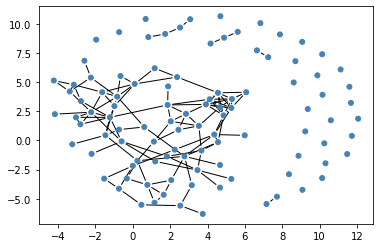

In [205]:
import igraph as ig
import matplotlib.pyplot as plt

dist = np.where(dist == 0, 1, dist) # For the boolean below. Can't figure out compound boolean.

g = ig.Graph.Adjacency(dist < cutoff) # Need to convert to boolean
g = g.as_undirected()

if dat.shape[0] <= 1000:
    fig, ax = plt.subplots()
    ig.plot(g, target=ax)

Now we will do a quick measure of betweenness and eigenvector centrality to get a feel for what questions are the most central. We'll print the top 10 of each.

In [206]:
deg = g.degree()
btw = g.betweenness()
dat['degree'] = g.degree()
dat['betweenness'] = g.betweenness()
display(dat.sort_values(by='degree', ascending=False))
display(dat.sort_values(by='betweenness', ascending=False))

,Person,Source,Link,Question,degree,betweenness
51,Daniel Schmachtenberger,Dharma Inquiiry,https://civilizationemerging.com/dharma-inquiry/,"If I was meaningfully smarter than I currently am, what would I do and how would I be differently?",8,85.937787
50,Daniel Schmachtenberger,Dharma Inquiiry,https://civilizationemerging.com/dharma-inquiry/,"If I was a lot more confident/ less fearful, what would I do and how would I be differently?",8,110.918720
80,Daniel Schmachtenberger,Dharma Inquiiry,https://civilizationemerging.com/dharma-inquiry/,"What do I enjoy doing for its own sake, independent of producing results or getting acknowledgement?",8,474.730586
52,Daniel Schmachtenberger,Dharma Inquiiry,https://civilizationemerging.com/dharma-inquiry/,"If I had much better discipline, what would I do and how would I be differently?",8,89.841132
82,Daniel Schmachtenberger,Dharma Inquiiry,https://civilizationemerging.com/dharma-inquiry/,What am I intrinsically fascinated by? Passionate about?,8,256.540476
...,...,...,...,...,...,...
49,Daniel Schmachtenberger,Dharma Inquiiry,https://civilizationemerging.com/dharma-inquiry/,"If I could download skills matrix style, what would the top few most desired be?",0,0.000000
37,Daniel Schmachtenberger,Civilization Emerging,https://civilizationemerging.com/,"How would we best account for types of value that are real but aren’t quantifiable, extractable, and exchangeable, in relationship to the types of value that are…factoring the relative power conferred by the latter type?",0,0.000000
20,Tim Ferriss,Tribe of Mentors,https://tim.blog/2017/10/03/tribe-of-mentors/,"If you could have a gigantic billboard anywhere with anything on it — metaphorically speaking, getting a message out to millions or billions — what would it say and why?",0,0.000000
73,Daniel Schmachtenberger,Dharma Inquiiry,https://civilizationemerging.com/dharma-inquiry/,What is the basis of meaningfulness?,0,0.000000


,Person,Source,Link,Question,degree,betweenness
98,Daniel Schmachtenberger,Dharma Inquiiry,https://civilizationemerging.com/dharma-inquiry/,What parts of my life would not engender the respect of those whom I respect the most?,7,560.282143
80,Daniel Schmachtenberger,Dharma Inquiiry,https://civilizationemerging.com/dharma-inquiry/,"What do I enjoy doing for its own sake, independent of producing results or getting acknowledgement?",8,474.730586
67,Daniel Schmachtenberger,Dharma Inquiiry,https://civilizationemerging.com/dharma-inquiry/,What would you spend your time working on if you could succeed but no one would ever know that you did it?,6,348.968995
60,Daniel Schmachtenberger,Dharma Inquiiry,https://civilizationemerging.com/dharma-inquiry/,What virtues would you most want to increase in yourself? Why those ones?,6,296.908126
91,Daniel Schmachtenberger,Dharma Inquiiry,https://civilizationemerging.com/dharma-inquiry/,"Where are there incongruences in my self, between my values and my actions…between some desires and other desires…between my habits and the expression of my highest vision…?",7,280.897619
...,...,...,...,...,...,...
33,Daniel Schmachtenberger,Civilization Emerging,https://civilizationemerging.com/,How would we best identify and internalize externalities in the decision making process?,0,0.000000
32,Daniel Schmachtenberger,Civilization Emerging,https://civilizationemerging.com/,"How do we do adequate safety analysis on radically unprecedented, complex, and consequential technologies like artificial intelligence and synthetic biology? Moreover, how do we bind the development of these technologies to those safety analyses and ensure that they are neither weaponized nor deployed negligently?",0,0.000000
29,Daniel Schmachtenberger,Civilization Emerging,https://civilizationemerging.com/,How do we create a world that is antifragile factoring increasingly decentralized exponential technologies?,0,0.000000
28,Tim Ferriss,Tribe of Mentors,https://tim.blog/2017/10/03/tribe-of-mentors/,"When you feel overwhelmed or unfocused, or have lost your focus temporarily, what do you do? (If helpful: What questions do you ask yourself?)",2,0.000000


From here, we run clustering to see if the the quesitons group into particular themes. We will use Louvain clustering, as it is often used in graph-based analysis.

In [207]:
clust = ig.Graph.community_multilevel(g)
#df = pd.DataFrame({'name': dat['Question'], 'cluster': clust.membership})
dat['cluster'] = clust.membership

# Get cluster ID, mine the per-cluster topics
for i in pd.unique(dat['cluster']):
    curr = dat[dat['cluster'] == i]
    if curr.shape[0] > 5:
        display(curr.sort_values(by='degree', ascending=False))
        

,Person,Source,Link,Question,degree,betweenness,cluster
67,Daniel Schmachtenberger,Dharma Inquiiry,https://civilizationemerging.com/dharma-inquiry/,What would you spend your time working on if you could succeed but no one would ever know that you did it?,6,348.968995,1
46,Daniel Schmachtenberger,Dharma Inquiiry,https://civilizationemerging.com/dharma-inquiry/,"If my financial needs were already met for the rest of my life, what would I do?",5,98.783463,1
47,Daniel Schmachtenberger,Dharma Inquiiry,https://civilizationemerging.com/dharma-inquiry/,"If I had the wealth of Bill Gates or Warren Buffet, what would I do with my life and resources?",5,48.641980,1
2,Tim Ferriss,17 questions that changed my life,https://tim.blog/wp-content/uploads/2020/01/17-Questions-That-Changed-My-Life.pdf,What would I do/have/be if I had $10 million? What’s my real TMI?,4,113.869674,1
1,Tim Ferriss,17 questions that changed my life,https://tim.blog/wp-content/uploads/2020/01/17-Questions-That-Changed-My-Life.pdf,What do I spend a silly amount of money on? How might I scratch my own itch?,3,94.696429,1
15,Tim Ferriss,17 questions that changed my life,https://tim.blog/wp-content/uploads/2020/01/17-Questions-That-Changed-My-Life.pdf,How can I throw money at this problem? How can I “waste” money to improve the quality of my life?,3,19.324123,1
19,Tim Ferriss,Tribe of Mentors,https://tim.blog/2017/10/03/tribe-of-mentors/,"How hHow has a failure, or apparent failure, set you up for later success? Do you have a “favorite failure” of yours?as a failure, or apparent failure, set you up for later success?",1,0.000000,1


,Person,Source,Link,Question,degree,betweenness,cluster
98,Daniel Schmachtenberger,Dharma Inquiiry,https://civilizationemerging.com/dharma-inquiry/,What parts of my life would not engender the respect of those whom I respect the most?,7,560.282143,13
60,Daniel Schmachtenberger,Dharma Inquiiry,https://civilizationemerging.com/dharma-inquiry/,What virtues would you most want to increase in yourself? Why those ones?,6,296.908126,13
18,Tim Ferriss,Tribe of Mentors,https://tim.blog/2017/10/03/tribe-of-mentors/,What purchase of $100 or less has most positively impacted your life in the last six months (or in recent memory)?,4,145.920489,13
68,Daniel Schmachtenberger,Dharma Inquiiry,https://civilizationemerging.com/dharma-inquiry/,What few qualities would you most want to increase in everyone if you could?,4,200.364835,13
16,Tim Ferriss,Tribe of Mentors,https://tim.blog/2017/10/03/tribe-of-mentors/,"What is the book (or books) you’ve given most as a gift, and why?",3,31.496429,13
58,Daniel Schmachtenberger,Dharma Inquiiry,https://civilizationemerging.com/dharma-inquiry/,Who are you most inspired by (that you personally know or figures from history)? What about them inspires you?,3,115.786905,13
17,Tim Ferriss,Tribe of Mentors,https://tim.blog/2017/10/03/tribe-of-mentors/,what are one to three books that have greatly influenced your life?,2,25.283333,13
22,Tim Ferriss,Tribe of Mentors,https://tim.blog/2017/10/03/tribe-of-mentors/,What is one of the best or most worthwhile investments you’ve ever made?,2,0.000000,13
24,Tim Ferriss,Tribe of Mentors,https://tim.blog/2017/10/03/tribe-of-mentors/,"In the last five years, what new belief, behavior, or habit has most improved your life?",2,97.090727,13
59,Daniel Schmachtenberger,Dharma Inquiiry,https://civilizationemerging.com/dharma-inquiry/,Who do you respect the most? What about them?,2,155.620238,13


,Person,Source,Link,Question,degree,betweenness,cluster
80,Daniel Schmachtenberger,Dharma Inquiiry,https://civilizationemerging.com/dharma-inquiry/,"What do I enjoy doing for its own sake, independent of producing results or getting acknowledgement?",8,474.730586,19
82,Daniel Schmachtenberger,Dharma Inquiiry,https://civilizationemerging.com/dharma-inquiry/,What am I intrinsically fascinated by? Passionate about?,8,256.540476,19
81,Daniel Schmachtenberger,Dharma Inquiiry,https://civilizationemerging.com/dharma-inquiry/,What is my attention repeatedly called to? What can I not not pay attention to?,4,60.716667,19
92,Daniel Schmachtenberger,Dharma Inquiiry,https://civilizationemerging.com/dharma-inquiry/,Where is my sense of limited capacity constraining what I focus on?,4,34.750000,19
77,Daniel Schmachtenberger,Dharma Inquiiry,https://civilizationemerging.com/dharma-inquiry/,What am I naturally good at? What seems to come easy to me? (Looking at strengths and aptitudes more than specific skills.),3,0.000000,19
93,Daniel Schmachtenberger,Dharma Inquiiry,https://civilizationemerging.com/dharma-inquiry/,"Where am I acting out of reaction, habit, or unconsciousness?",3,75.550000,19
101,Daniel Schmachtenberger,Dharma Inquiiry,https://civilizationemerging.com/dharma-inquiry/,What do I do because I’m good at it but don’t really like it or care about it deeply?,3,0.000000,19
28,Tim Ferriss,Tribe of Mentors,https://tim.blog/2017/10/03/tribe-of-mentors/,"When you feel overwhelmed or unfocused, or have lost your focus temporarily, what do you do? (If helpful: What questions do you ask yourself?)",2,0.000000,19
78,Daniel Schmachtenberger,Dharma Inquiiry,https://civilizationemerging.com/dharma-inquiry/,What types of activities do I feel replenished by?,2,33.000000,19
64,Daniel Schmachtenberger,Dharma Inquiiry,https://civilizationemerging.com/dharma-inquiry/,What do you find the most beauty in? What are you most moved by?,1,0.000000,19


,Person,Source,Link,Question,degree,betweenness,cluster
69,Daniel Schmachtenberger,Dharma Inquiiry,https://civilizationemerging.com/dharma-inquiry/,What would you sacrifice personal benefit for?,5,146.055128,27
72,Daniel Schmachtenberger,Dharma Inquiiry,https://civilizationemerging.com/dharma-inquiry/,What are you devoted to? What does devotion mean?,5,202.954396,27
76,Daniel Schmachtenberger,Dharma Inquiiry,https://civilizationemerging.com/dharma-inquiry/,"If all your personal desires were already met, what would you then desire or care about?",4,213.450366,27
70,Daniel Schmachtenberger,Dharma Inquiiry,https://civilizationemerging.com/dharma-inquiry/,What is more important to you than your own life?,3,71.784524,27
74,Daniel Schmachtenberger,Dharma Inquiiry,https://civilizationemerging.com/dharma-inquiry/,What are you loyal to? What does loyalty mean? What would be an adequate reason to violate a loyalty?,2,33.625000,27
38,Daniel Schmachtenberger,Civilization Emerging,https://civilizationemerging.com/,How can we change the topology of incentive landscapes in the direction towards long term life enhancement?,1,0.000000,27
71,Daniel Schmachtenberger,Dharma Inquiiry,https://civilizationemerging.com/dharma-inquiry/,What is sacred to you? What does sacred mean?,1,0.000000,27
79,Daniel Schmachtenberger,Dharma Inquiiry,https://civilizationemerging.com/dharma-inquiry/,What am I willing to do even if it taxes me?,1,0.000000,27


,Person,Source,Link,Question,degree,betweenness,cluster
50,Daniel Schmachtenberger,Dharma Inquiiry,https://civilizationemerging.com/dharma-inquiry/,"If I was a lot more confident/ less fearful, what would I do and how would I be differently?",8,110.918720,32
51,Daniel Schmachtenberger,Dharma Inquiiry,https://civilizationemerging.com/dharma-inquiry/,"If I was meaningfully smarter than I currently am, what would I do and how would I be differently?",8,85.937787,32
52,Daniel Schmachtenberger,Dharma Inquiiry,https://civilizationemerging.com/dharma-inquiry/,"If I had much better discipline, what would I do and how would I be differently?",8,89.841132,32
53,Daniel Schmachtenberger,Dharma Inquiiry,https://civilizationemerging.com/dharma-inquiry/,"If I was better with people (more understanding, charismatic, empathetic, patient, etc.), what would I do and how would I be differently?",8,117.033150,32
54,Daniel Schmachtenberger,Dharma Inquiiry,https://civilizationemerging.com/dharma-inquiry/,"If I had better emotional regulation, what would I do and how would I be differently?",7,8.835387,32
56,Daniel Schmachtenberger,Dharma Inquiiry,https://civilizationemerging.com/dharma-inquiry/,"If I had the right team and people supporting me, what would I do and how would I be differently?",7,59.852950,32
57,Daniel Schmachtenberger,Dharma Inquiiry,https://civilizationemerging.com/dharma-inquiry/,"If my life started over with a clean slate (no previous commitments, baggage, etc.), what would I do and how would I be differently?",7,38.947749,32
55,Daniel Schmachtenberger,Dharma Inquiiry,https://civilizationemerging.com/dharma-inquiry/,"If my main character deficits were resolved, what would I do and how would I be differently?",3,0.000000,32


,Person,Source,Link,Question,degree,betweenness,cluster
62,Daniel Schmachtenberger,Dharma Inquiiry,https://civilizationemerging.com/dharma-inquiry/,What issues in the world upset you the most?,5,74.016667,33
75,Daniel Schmachtenberger,Dharma Inquiiry,https://civilizationemerging.com/dharma-inquiry/,What do you feel shame or guilt about?,4,217.552381,33
61,Daniel Schmachtenberger,Dharma Inquiiry,https://civilizationemerging.com/dharma-inquiry/,What types of behavior and people bother you the most?,3,77.973810,33
63,Daniel Schmachtenberger,Dharma Inquiiry,https://civilizationemerging.com/dharma-inquiry/,What do you see as most deeply wrong with or off in the world?,3,11.133333,33
66,Daniel Schmachtenberger,Dharma Inquiiry,https://civilizationemerging.com/dharma-inquiry/,What news stories about the world would you be most positively moved to see?,2,0.000000,33
85,Daniel Schmachtenberger,Dharma Inquiiry,https://civilizationemerging.com/dharma-inquiry/,What have been the greatest difficulties/pains in my life?,2,0.000000,33


,Person,Source,Link,Question,degree,betweenness,cluster
91,Daniel Schmachtenberger,Dharma Inquiiry,https://civilizationemerging.com/dharma-inquiry/,"Where are there incongruences in my self, between my values and my actions…between some desires and other desires…between my habits and the expression of my highest vision…?",7,280.897619,34
94,Daniel Schmachtenberger,Dharma Inquiiry,https://civilizationemerging.com/dharma-inquiry/,"Where do I feel trapped by past choices (loyalties, commitments, debts, investments, etc.)?",6,119.788095,34
83,Daniel Schmachtenberger,Dharma Inquiiry,https://civilizationemerging.com/dharma-inquiry/,Where have I felt the most pride/satisfaction related to something I did?,5,240.433333,34
87,Daniel Schmachtenberger,Dharma Inquiiry,https://civilizationemerging.com/dharma-inquiry/,"Where are my goals the result of compensations to old wounds? (Proving that I’m enough, proving something to parents or a parental archetype projected on the world, seeking validation externally, proving we aren’t like our parents, etc.)",5,91.114286,34
88,Daniel Schmachtenberger,Dharma Inquiiry,https://civilizationemerging.com/dharma-inquiry/,"Where am I still running the programs of my childhood (early models of success, of who I am, of what I’m capable of, of what’s meaningful…)",5,61.333333,34
90,Daniel Schmachtenberger,Dharma Inquiiry,https://civilizationemerging.com/dharma-inquiry/,Where is fear influencing my choices?,3,83.619048,34
95,Daniel Schmachtenberger,Dharma Inquiiry,https://civilizationemerging.com/dharma-inquiry/,Where are lack of self worth or self trust keeping me from showing up in greater service to what I care about?,3,209.933333,34
96,Daniel Schmachtenberger,Dharma Inquiiry,https://civilizationemerging.com/dharma-inquiry/,Where is credit seeking or image management influencing how I’m choosing?,2,0.000000,34
99,Daniel Schmachtenberger,Dharma Inquiiry,https://civilizationemerging.com/dharma-inquiry/,Where is my success occurring at the expense of others?,2,3.642857,34
100,Daniel Schmachtenberger,Dharma Inquiiry,https://civilizationemerging.com/dharma-inquiry/,Where does my life feel imbalanced?,2,0.000000,34


Now, we're going to pull the graph out as an edgelist and get a feel for who is connected to who. We will then export the edgelist for import into Neo4J. 

In [208]:
el = g.get_edge_dataframe()
el

,source,target
edge ID,,
0,1,2
1,0,3
2,1,15
3,16,17
4,1,18
...,...,...
123,91,100
124,94,100
125,77,101


Now we have to convert the edges from their edge IDs to the questions that are in the order of the IDs. The reason we're seeing numbers right now is that the original adjacency matrix was made with the IDs and not the questions themselves. We're going to do that using a simple conversion function. We're going to do this by creating a dictionary. 

In [209]:
q_dict = {}

for i in range(0, len(sentences)):
    q_dict[i] = sentences[i]


In [210]:
e1 = [q_dict[i] for i in el['source']]
e2 = [q_dict[i] for i in el['target']]

el_df = pd.DataFrame({'edge1': e1, 'edge2': e2})
el_df 



,edge1,edge2
0,What do I spend a silly amount of money on? How might I scratch my own itch?,What would I do/have/be if I had $10 million? What’s my real TMI?
1,What if I did the opposite for 48 hours?,What are the worst things that could happen? Could I get back here?
2,What do I spend a silly amount of money on? How might I scratch my own itch?,How can I throw money at this problem? How can I “waste” money to improve the quality of my life?
3,"What is the book (or books) you’ve given most as a gift, and why?",what are one to three books that have greatly influenced your life?
4,What do I spend a silly amount of money on? How might I scratch my own itch?,What purchase of $100 or less has most positively impacted your life in the last six months (or in recent memory)?
...,...,...
123,"Where are there incongruences in my self, between my values and my actions…between some desires and other desires…between my habits and the expression of my highest vision…?",Where does my life feel imbalanced?
124,"Where do I feel trapped by past choices (loyalties, commitments, debts, investments, etc.)?",Where does my life feel imbalanced?
125,What am I naturally good at? What seems to come easy to me? (Looking at strengths and aptitudes more than specific skills.),What do I do because I’m good at it but don’t really like it or care about it deeply?
126,"What do I enjoy doing for its own sake, independent of producing results or getting acknowledgement?",What do I do because I’m good at it but don’t really like it or care about it deeply?


In [211]:
el_df.to_csv('../output/' + dataset + '_' + model_name + '_edgelist_dist_' + str(cutoff) + '.csv', encoding='utf-8-sig')
dat.to_csv('../output/' + dataset + '_' + model_name + '_analyzed_' + str(cutoff) + '.csv', encoding='utf-8-sig')